# Precip & Helicity

## Setup

In [13]:
# Import statements
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy.ma as ma
import numpy as np
import matplotlib.colors as colors
import scipy.stats as stats
import xskillscore as xs
from dask.diagnostics import ProgressBar

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Create function to open_mfdataset and add time dimension
def load_data(init : str, keyword : str) -> xr.Dataset:
    
    # Note that this function depends on a consistent file structure so if you
    # change that, you'll need to change this function.
    # First, determine starting date
    start_date = "2021-09-02" if init in ["00Z","01Z"] else "2021-09-01"
    new_dates = xr.date_range(
        start=start_date+" "+init[:-1]+":00:00",
        end="2021-09-02 "+str((int(init[:-1])+6)%24).zfill(2)+":00:00",
        freq="5min",
        use_cftime=True
    )

    # read in data
    data = xr.open_mfdataset(
        "/mnt/drive2/wof-runs/post-processed/"+init+"/wofs_"+keyword.upper()+"*.nc",
        concat_dim="time",combine="nested"
    )
    data["time"] = new_dates
    return(data)

## Read in data

In [3]:
ens = [load_data(i,"ens") for i in ["20Z","21Z","22Z","23Z","00Z","01Z"]]
ens = [e.assign_coords(lat=e.lat,lon=e.lon,ne=e.ne) for e in ens]

# Make a new DataArray
init = xr.DataArray(data=["20Z","21Z","22Z","23Z","00Z","01Z"],dims="init")
init = init.assign_coords({"init":init})

# concat
ens = xr.concat(ens,dim=init)

# grab UH and rain
rain = ens.rain
uh = ens.uh_0to2

In [4]:
# Set desired latitude and longitude
nyc_lat,nyc_lon = 40.7826,-73.9656

# Isolate XLAT and XLONG for ease of use
lat = ens.xlat.isel(time=0,init=0)
lon = ens.xlon.isel(time=0,init=0)

# Calculate the Euclidean distance between lat and lon values and the desired point
distance = np.sqrt((lat-nyc_lat)**2 + (lon-nyc_lon)**2)

# Find where the distance is minimized
nyc_inds = distance.argmin(dim=["NY","NX"])
NY_ind, NX_ind = int(nyc_inds["NY"]),int(nyc_inds["NX"])

## Scatterplots

In [8]:
rain_1to2Z_sum = rain.sel(time=slice("2021-09-02 01:00:00","2021-09-02 02:00:00")).sum(
    dim="time"
).chunk({"init":-1})
uh_1to2Z_max = uh.sel(time=slice("2021-09-02 01:00:00","2021-09-02 02:00:00")).max(
    dim="time"
).rolling(lat=5,lon=5,center=True).max().chunk({"init":-1})

In [43]:
# Get the ensemble mean, 90th percentile, and ensemble max to plot
x = [rain_1to2Z_sum.mean(dim=["init","ne"]),
     rain_1to2Z_sum.quantile(0.9,dim=["init","ne"]),
     rain_1to2Z_sum.max(dim=["init","ne"])]
y = [uh_1to2Z_max.mean(dim=["init","ne"]),
     uh_1to2Z_max.quantile(0.9,dim=["init","ne"]),
     uh_1to2Z_max.max(dim=["init","ne"])]
with ProgressBar():
    x = [xi.compute() for xi in x]
    y = [yi.compute() for yi in y]
r = [xs.spearman_r(xi,yi,skipna=True) for xi,yi in zip(x,y)]


[########################################] | 100% Completed | 1.35 sms
[########################################] | 100% Completed | 8.44 sms
[########################################] | 100% Completed | 1.33 sms
[########################################] | 100% Completed | 1.86 sms
[########################################] | 100% Completed | 8.68 sms
[########################################] | 100% Completed | 1.66 sms


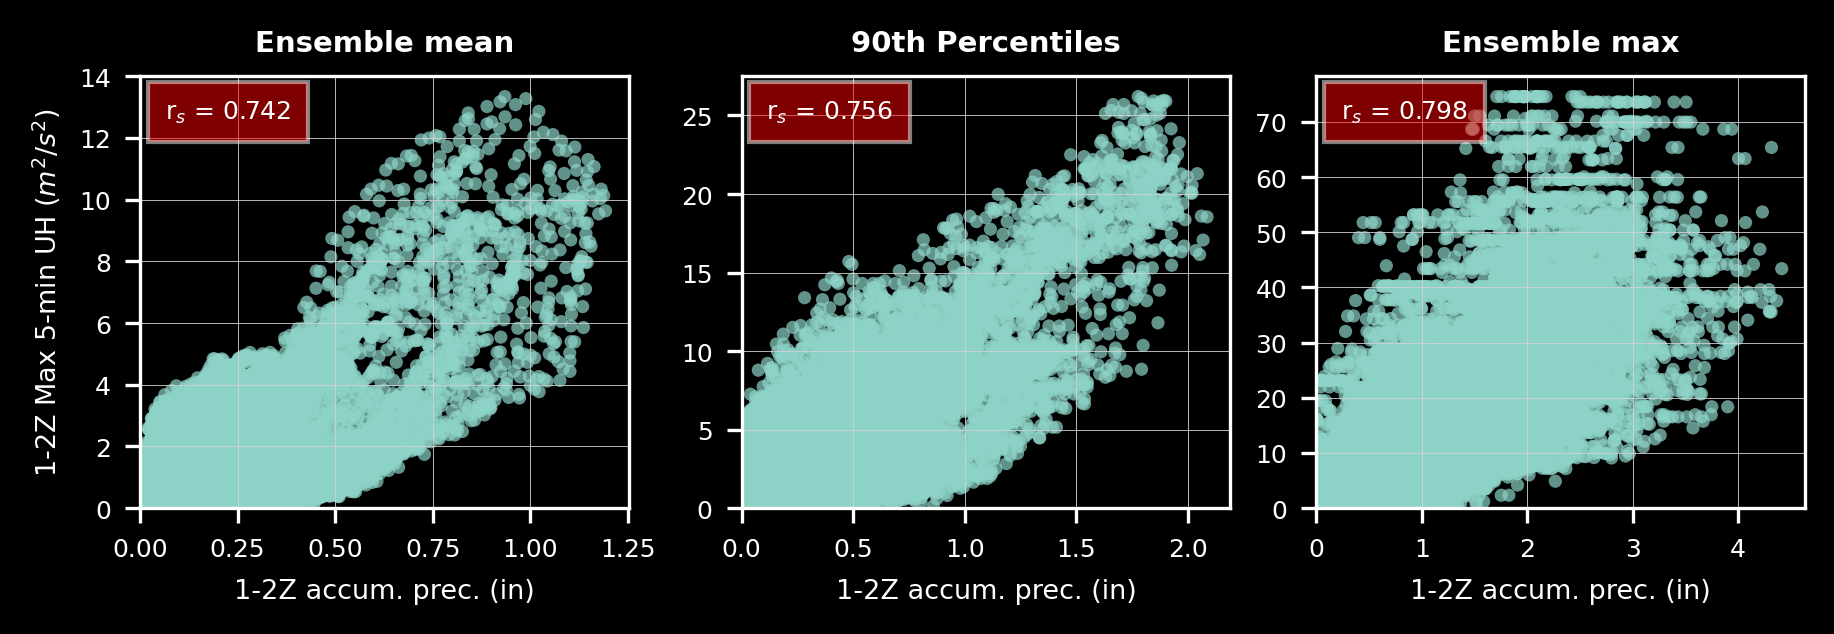

In [50]:
from pyproj import transform


plt.style.use("dark_background")
titles = ["Ensemble mean","90th Percentiles","Ensemble max"]

fig, axes = plt.subplots(1, 3,sharex=False,sharey=False,
                         dpi=300,layout="constrained",figsize=(6,2))
for i,ax in enumerate(axes):
    ax.scatter(x[i],y[i],s=10,alpha=0.7,edgecolors="none")
    ax.tick_params(axis="x",which="both",labelsize=6,labelbottom=True)
    ax.tick_params(axis="y",which="both",labelsize=6,labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i],fontsize=7,fontweight="bold")
    ax.set_xlim([0,None])
    ax.set_ylim([0,None])
    ax.set_xlabel("1-2Z accum. prec. (in)",fontsize=6.5)
    ax.text(0.05,0.9,"r$_s$ = "+str(float(r[i].round(3))),
            fontsize=6,bbox=dict(facecolor='red', alpha=0.5),
            transform=ax.transAxes)
    if(i==0):
        ax.set_ylabel("1-2Z Max 5-min UH ($m^2$/$s^2$)",fontsize=6.5)

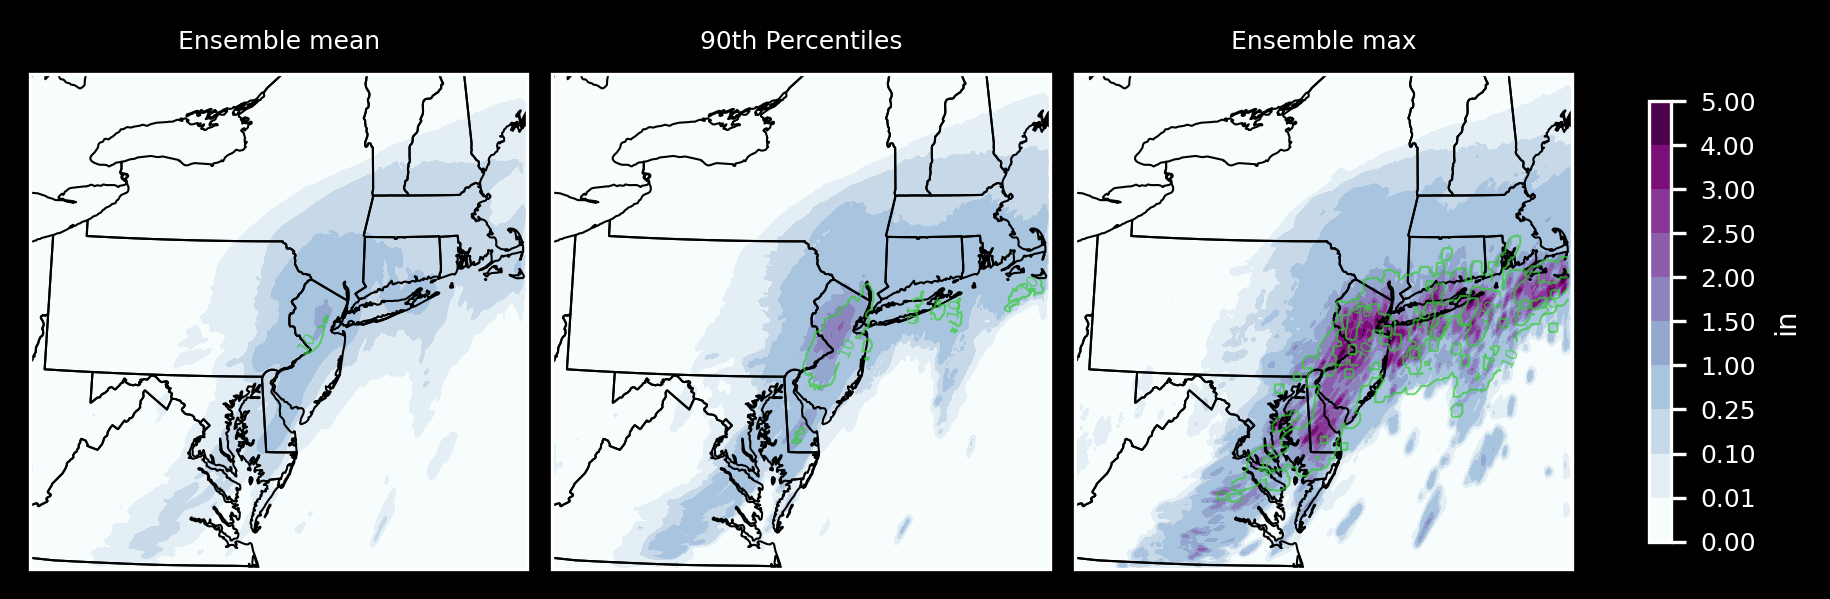

In [62]:
bounds=[0,0.01,0.1,0.25,1,1.5,2,2.5,3,4,5]
norm=colors.BoundaryNorm(boundaries=bounds,ncolors=256)

proj = ccrs.LambertConformal(central_longitude=ens.attrs['CEN_LON'],
                             central_latitude=ens.attrs['CEN_LAT'],
                             standard_parallels=(30,60))

lat = ens.xlat.isel(init=0,time=0)
lon = ens.xlon.isel(init=0,time=0)

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes.flatten()):
    p = ax.contourf(lon,lat,x[i],
                      transform=ccrs.PlateCarree(),
                      cmap="BuPu",norm=norm,levels=bounds)
    c = ax.contour(lon,lat,y[i],
                   colors="limegreen",transform=ccrs.PlateCarree(),linewidths=0.5,
                   levels=range(10,70,20),alpha=0.7)
    p.axes.add_feature(cfeature.STATES,linewidth=0.5)
    ax.clabel(c,c.levels,inline=True,fontsize=4)
    ax.set_title(titles[i],fontsize=6)

cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=20)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
cbar.set_ticks(bounds)

In [4]:
rain_1to2Z = [e.rain.sel(time=slice("2021-09-02 01:05:00",
                                   "2021-09-02 02:05:00")).sum(dim="time") for e in ens]
uh_1to2Z = [e.uh_0to2.sel(time=slice("2021-09-02 01:05:00",
                                   "2021-09-02 02:05:00")).max(dim="time") for e in ens]

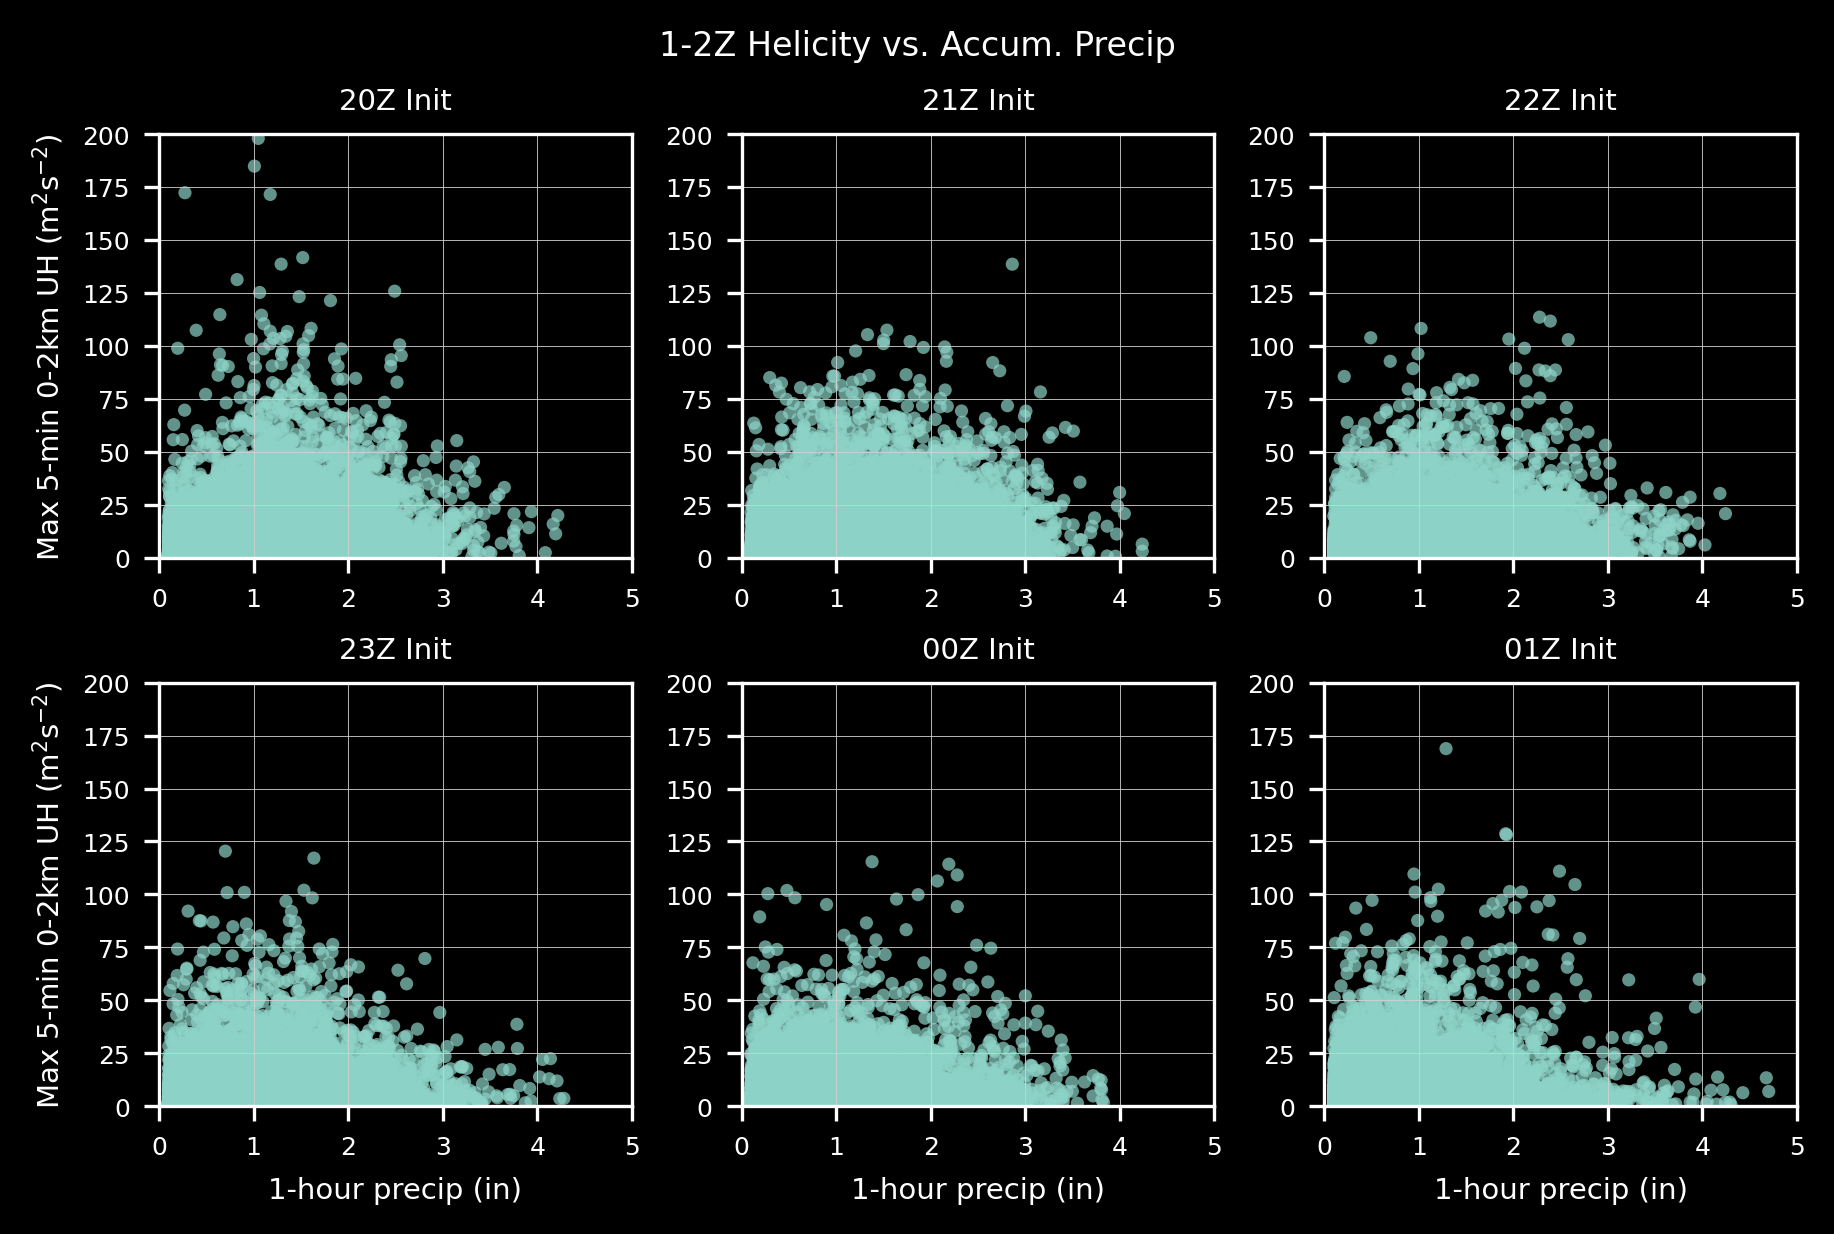

In [6]:
plt.style.use("dark_background")
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]

fig, axes = plt.subplots(2, 3,sharex=True,sharey=True,
                         dpi=300,layout="constrained",figsize=(6,4))

for i,ax in enumerate(axes.flatten()):
    ax.scatter(rain_1to2Z[i].where(rain_1to2Z[i]>0.1),
                uh_1to2Z[i].where(rain_1to2Z[i]>0.1),
                s=10,alpha=0.7,edgecolors="none")
    # slope,intercept=ma.polyfit(
    #     ma.masked_where(rain_1to2Z[i].values.flatten()<0.1,
    #                     rain_1to2Z[i].values.flatten()),
    #                     ma.masked_where(rain_1to2Z[i].values.flatten()<0.1,
    #                                     uh_1to2Z[i].values.flatten()),
    #                                     deg=1
    # )
    # ax.plot(np.arange(0,6,1),np.arange(0,6,1)*slope + intercept)
    ax.tick_params(axis="x",which="both",labelsize=6,labelbottom=True)
    ax.tick_params(axis="y",which="both",labelsize=6,labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    if(i in [3,4,5]):
        ax.set_xlabel("1-hour precip (in)",fontsize=7)
    if(i in [0,3]):
        ax.set_ylabel("Max 5-min 0-2km UH (m$^2$s$^{-2}$)",fontsize=7)
    ax.set_title(titles[i],fontsize=7)
    ax.set_xlim([0,5])
    ax.set_ylim([0,200])
plt.suptitle("1-2Z Helicity vs. Accum. Precip",fontsize=8)
plt.show()

In [7]:
# Maybe we should try a bigger neighborhood
uh_1to2Z_15km = [e.uh_0to2_instant.sel(time=slice("2021-09-02 01:05:00",
                                   "2021-09-02 02:05:00")).max(dim="time").rolling(
                                       lat=5,lon=5,min_periods=1,center=True
                                   ).max() for e in ens]

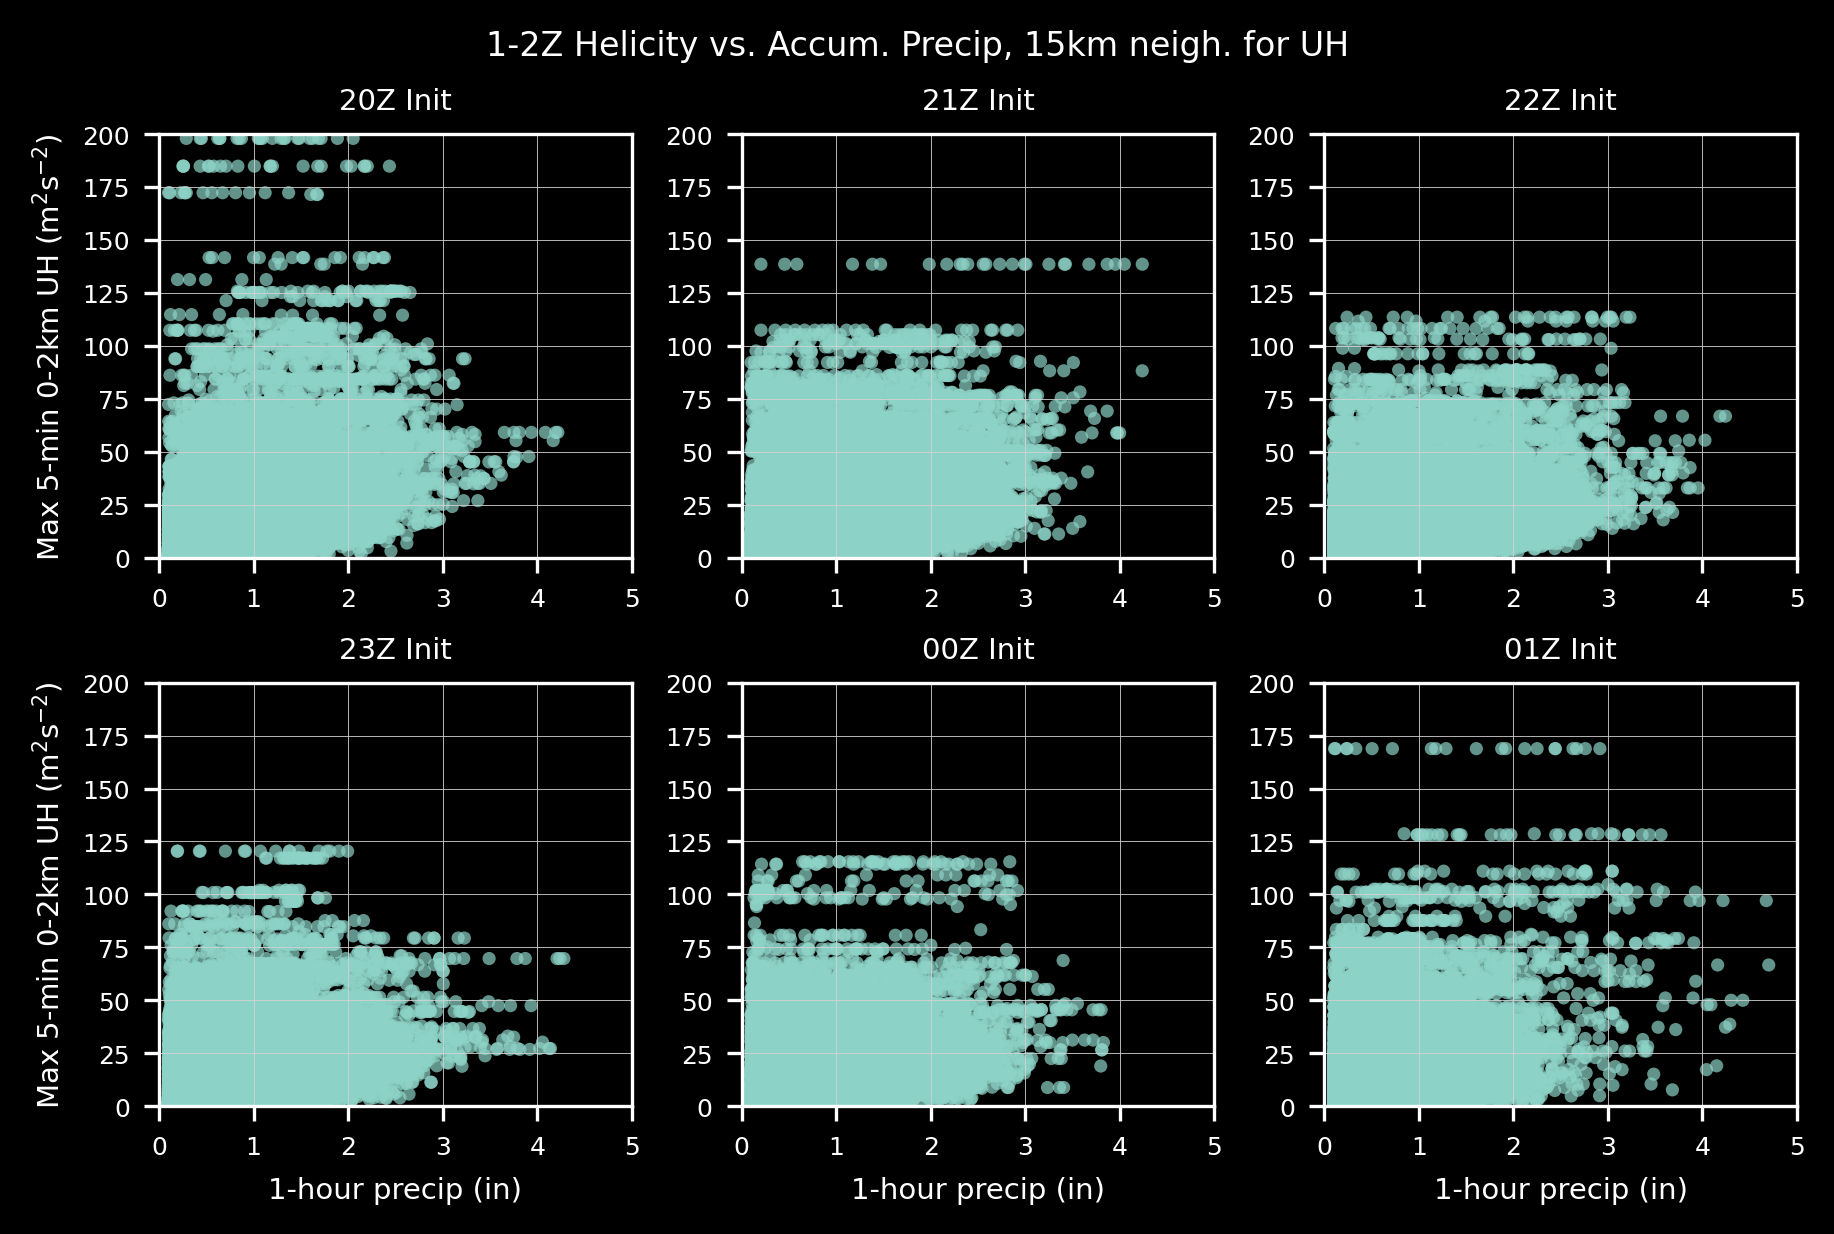

In [167]:
plt.style.use("dark_background")
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]

fig, axes = plt.subplots(2, 3,sharex=True,sharey=True,
                         dpi=300,layout="constrained",figsize=(6,4))

for i,ax in enumerate(axes.flatten()):
    ax.scatter(rain_1to2Z[i].where(rain_1to2Z[i]>0.1),
                uh_1to2Z_15km[i].where(rain_1to2Z[i]>0.1),
                s=10,alpha=0.7,edgecolors="none")
    # slope,intercept=ma.polyfit(
    #     ma.masked_where(rain_1to2Z[i].values.flatten()<0.1,
    #                     rain_1to2Z[i].values.flatten()),
    #                     ma.masked_where(rain_1to2Z[i].values.flatten()<0.1,
    #                                     uh_1to2Z[i].values.flatten()),
    #                                     deg=1
    # )
    # ax.plot(np.arange(0,6,1),np.arange(0,6,1)*slope + intercept)
    ax.tick_params(axis="x",which="both",labelsize=6,labelbottom=True)
    ax.tick_params(axis="y",which="both",labelsize=6,labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    if(i in [3,4,5]):
        ax.set_xlabel("1-hour precip (in)",fontsize=7)
    if(i in [0,3]):
        ax.set_ylabel("Max 5-min 0-2km UH (m$^2$s$^{-2}$)",fontsize=7)
    ax.set_title(titles[i],fontsize=7)
    ax.set_xlim([0,5])
    ax.set_ylim([0,200])
plt.suptitle("1-2Z Helicity vs. Accum. Precip, 15km neigh. for UH",fontsize=8)
plt.show()

## Spatial maps

In [5]:
# Calculate the 90th percentile and max of rain & uh
rain_1to2Z_90th = [r.quantile(0.9,dim="ne") for r in rain_1to2Z]
rain_1to2Z_max = [r.max(dim="ne") for r in rain_1to2Z]

uh_1to2Z_90th = [u.quantile(0.9,dim="ne") for u in uh_1to2Z]
uh_1to2Z_max = [u.max(dim="ne") for u in uh_1to2Z]

In [16]:
bounds=[0,0.01,0.1,0.25,1,1.5,2,2.5,3,4,5]
norm=colors.BoundaryNorm(boundaries=bounds,ncolors=256)

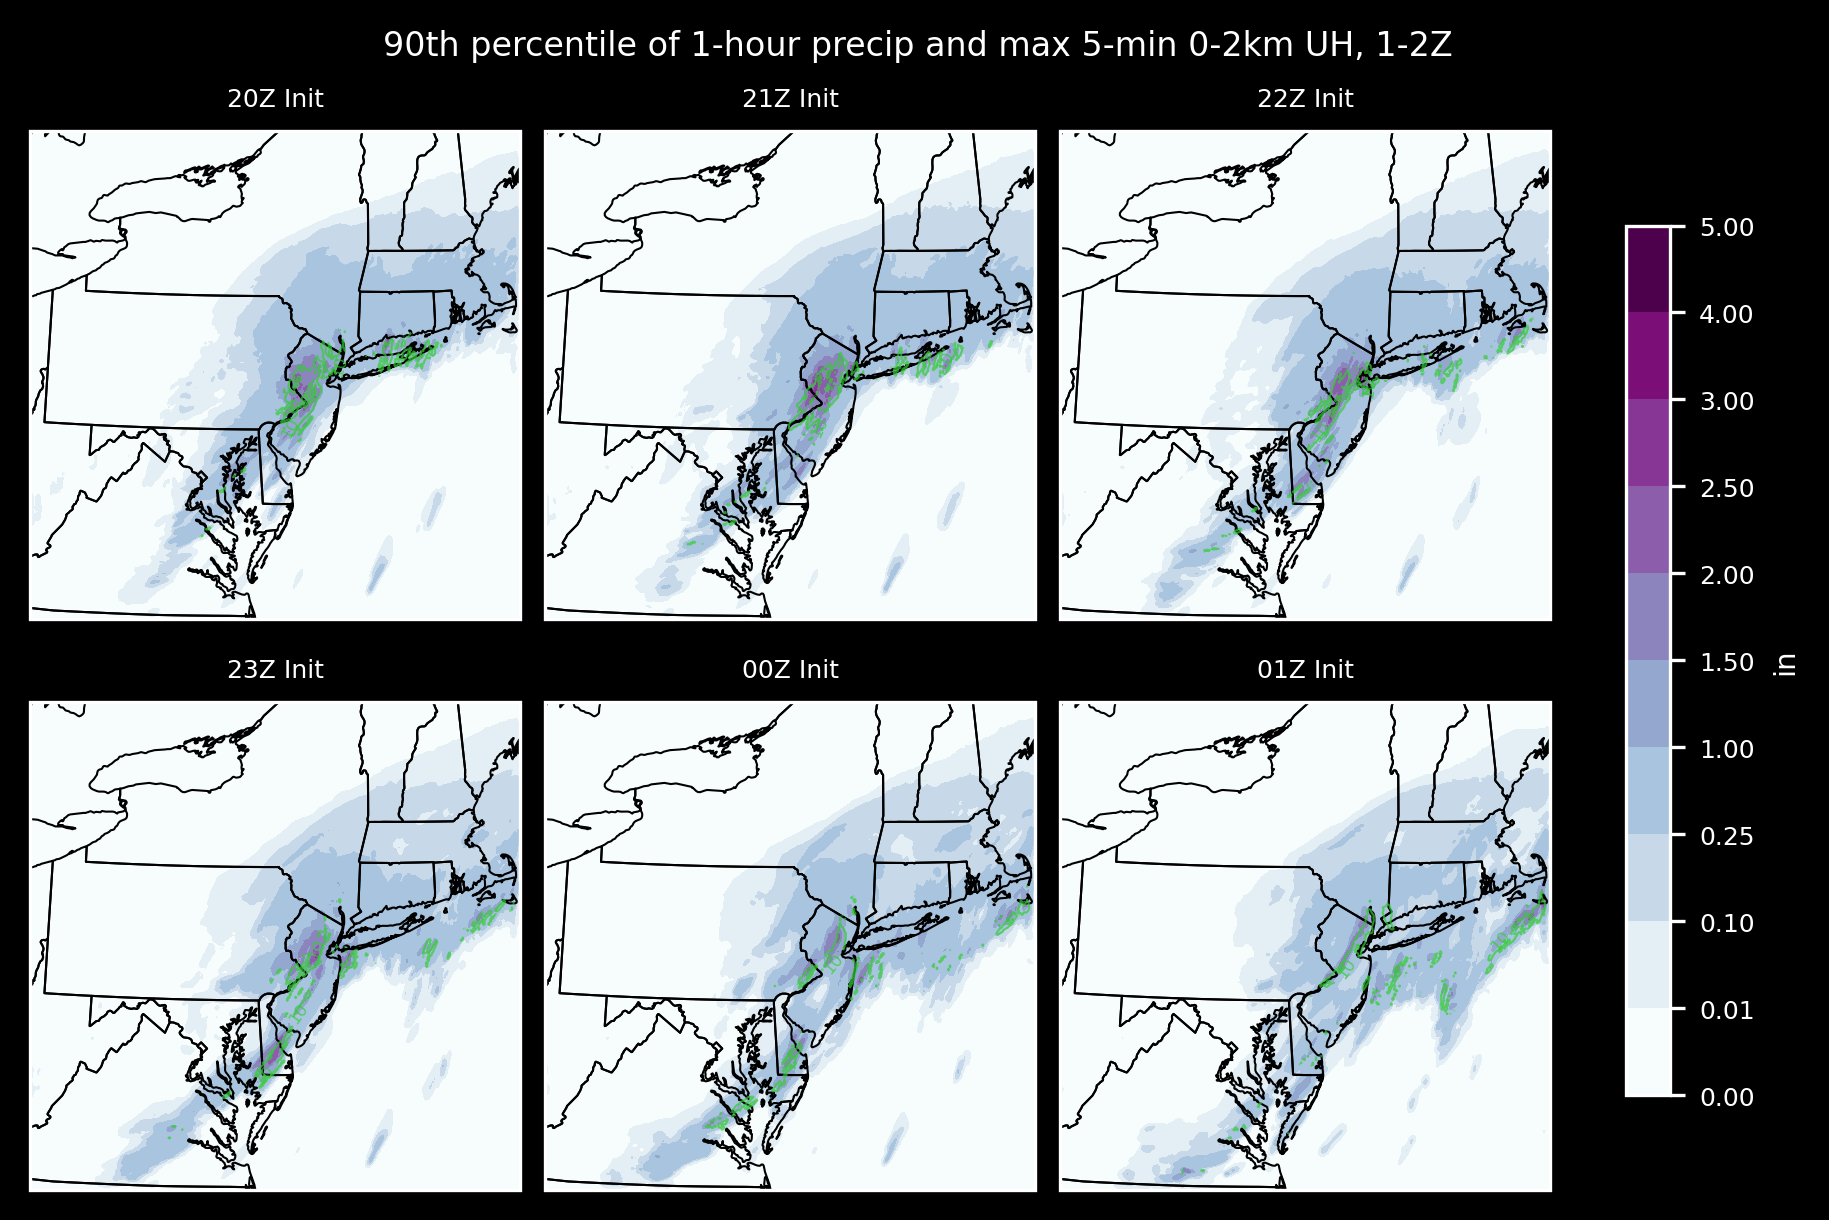

In [40]:
plt.style.use("dark_background")

linewidth=0.5
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,4))

for i,ax in enumerate(axes.flatten()):
    p = ax.contourf(lon,lat,rain_1to2Z_90th[i],
                      transform=ccrs.PlateCarree(),
                      cmap="BuPu",norm=norm,levels=bounds)
    c = ax.contour(lon,lat,uh_1to2Z_90th[i],
                   colors="limegreen",transform=ccrs.PlateCarree(),linewidths=0.5,
                   levels=range(10,70,20),alpha=0.7)
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.clabel(c,c.levels,inline=True,fontsize=4)
    ax.set_title(titles[i],fontsize=6)

cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=20)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
cbar.set_ticks(bounds)
plt.suptitle("90th percentile of 1-hour precip and max 5-min 0-2km UH, 1-2Z",fontsize=8)
plt.show()

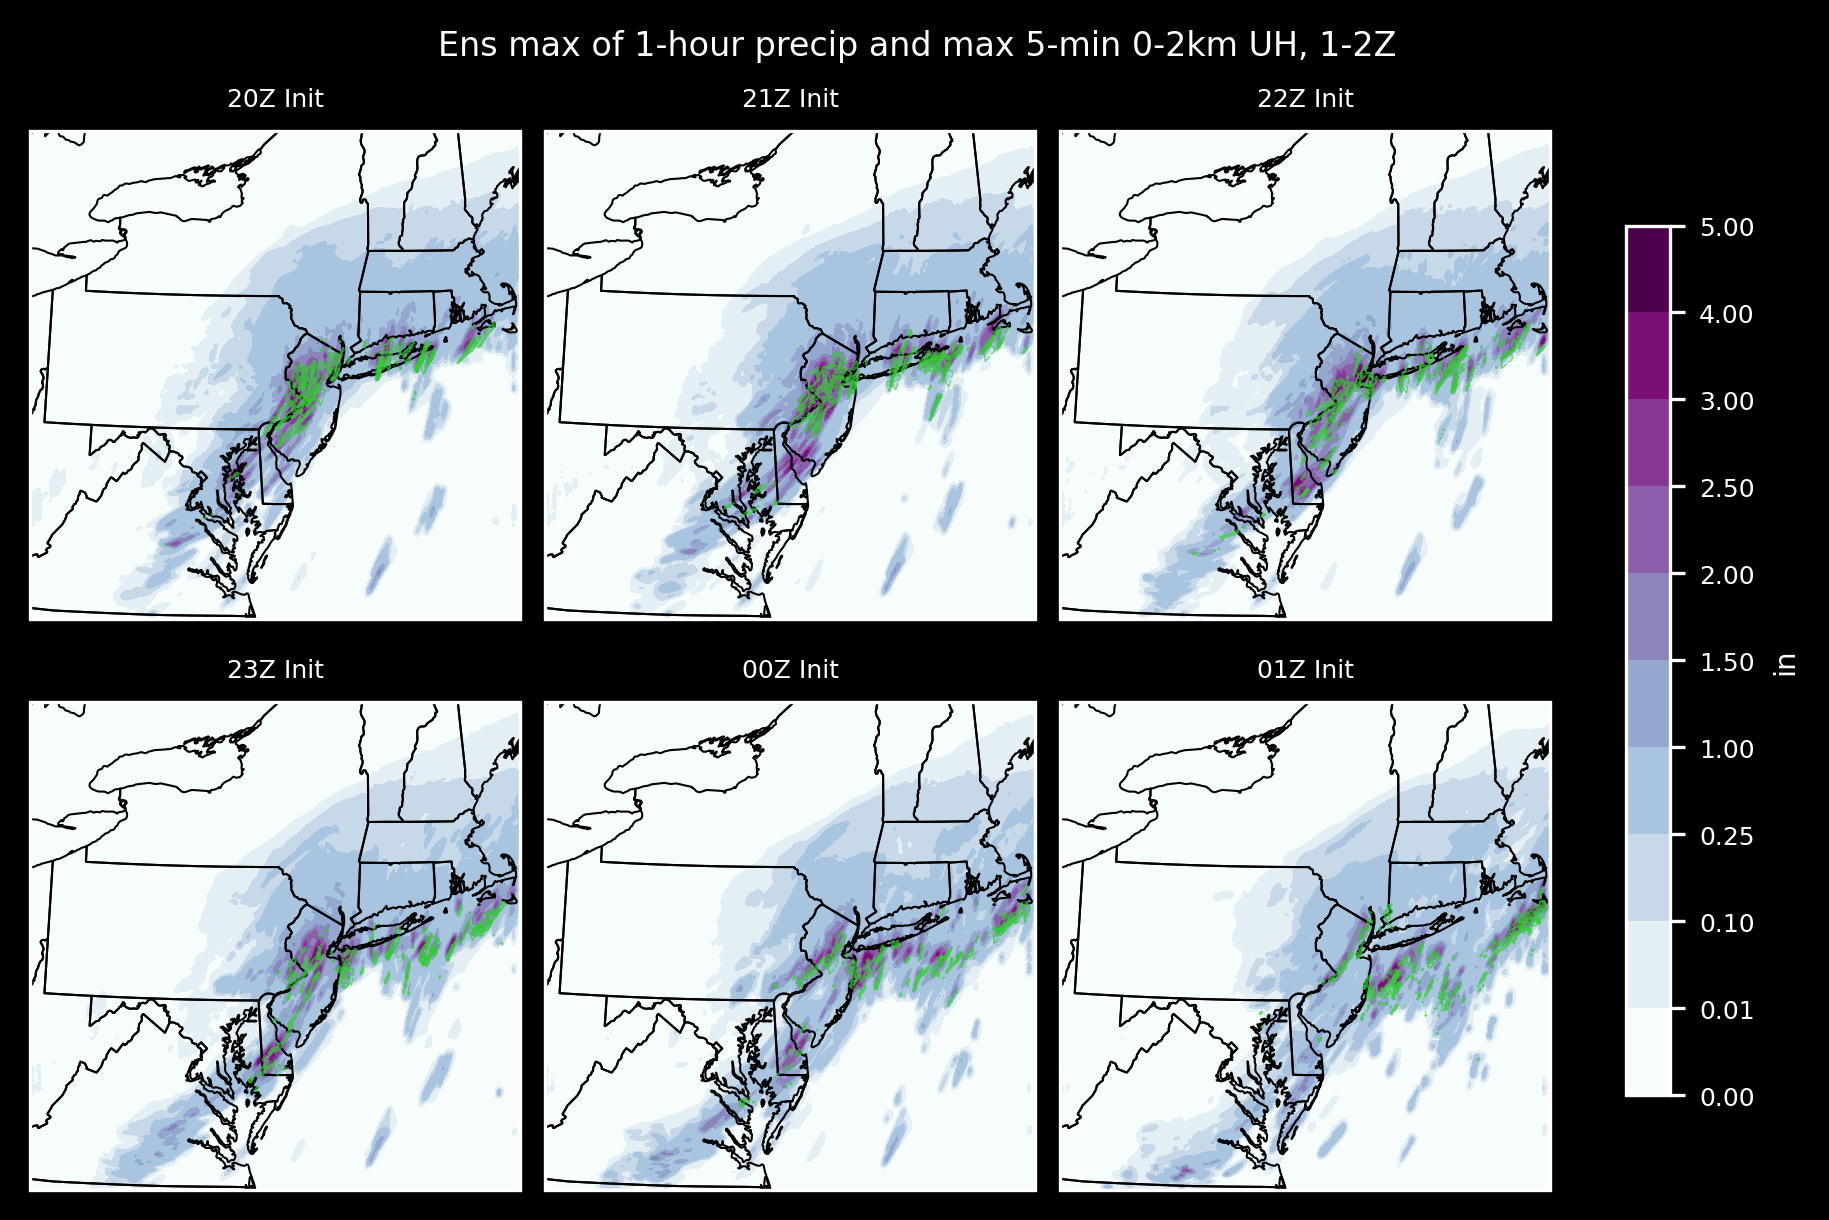

In [39]:
plt.style.use("dark_background")

linewidth=0.5
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,4))

for i,ax in enumerate(axes.flatten()):
    p = ax.contourf(lon,lat,rain_1to2Z_max[i],
                      transform=ccrs.PlateCarree(),
                      cmap="BuPu",norm=norm,levels=bounds)
    c = ax.contour(lon,lat,uh_1to2Z_max[i],
                   colors="limegreen",transform=ccrs.PlateCarree(),linewidths=0.5,
                   levels=range(25,201,25),alpha=0.7)
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.clabel(c,c.levels,inline=True,fontsize=4)
    ax.set_title(titles[i],fontsize=6)

cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=20)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
cbar.set_ticks(bounds)
plt.suptitle("Ens max of 1-hour precip and max 5-min 0-2km UH, 1-2Z",fontsize=8)
plt.show()

## Area average precip vs. max precip

In [6]:
# Calculate the area average and maximum hourly precip for a box around Central Park
aoi_48km = [r.isel(
    lat=slice(NY_ind-8,NY_ind+8),
    lon=slice(NX_ind-8,NX_ind+8)
) for r in rain_1to2Z]
avg_48km = [a.mean(dim=["lat","lon"]) for a in aoi_48km]
max_48km = [a.max(dim=["lat","lon"]) for a in aoi_48km]

aoi_96km = [r.isel(
    lat=slice(NY_ind-16,NY_ind+16),
    lon=slice(NX_ind-16,NX_ind+16)
) for r in rain_1to2Z]
avg_96km = [a.mean(dim=["lat","lon"]) for a in aoi_96km]
max_96km = [a.max(dim=["lat","lon"]) for a in aoi_96km]


In [11]:
# Concatenate our list of DataArrays
# Make a new DataArray
init = xr.DataArray(data=["20Z","21Z","22Z","23Z","00Z","01Z"],dims="init")
init = init.assign_coords({"init":init})

# Concatenate
avg_48km_da = xr.concat(avg_48km,dim=init)
max_48km_da = xr.concat(max_48km,dim=init)

avg_96km_da = xr.concat(avg_96km,dim=init)
max_96km_da = xr.concat(max_96km,dim=init)

In [35]:
xs = [avg_48km_da,avg_96km_da,avg_48km_da.sel(init=slice(None,"23Z")),
      avg_96km_da.sel(init=slice(None,"23Z"))]
ys = [max_48km_da,max_96km_da,max_48km_da.sel(init=slice(None,"23Z")),
      max_96km_da.sel(init=slice(None,"23Z"))]
rs = [stats.spearmanr(x.values.flatten(),y.values.flatten())[0] for x,y in zip(xs,ys)]

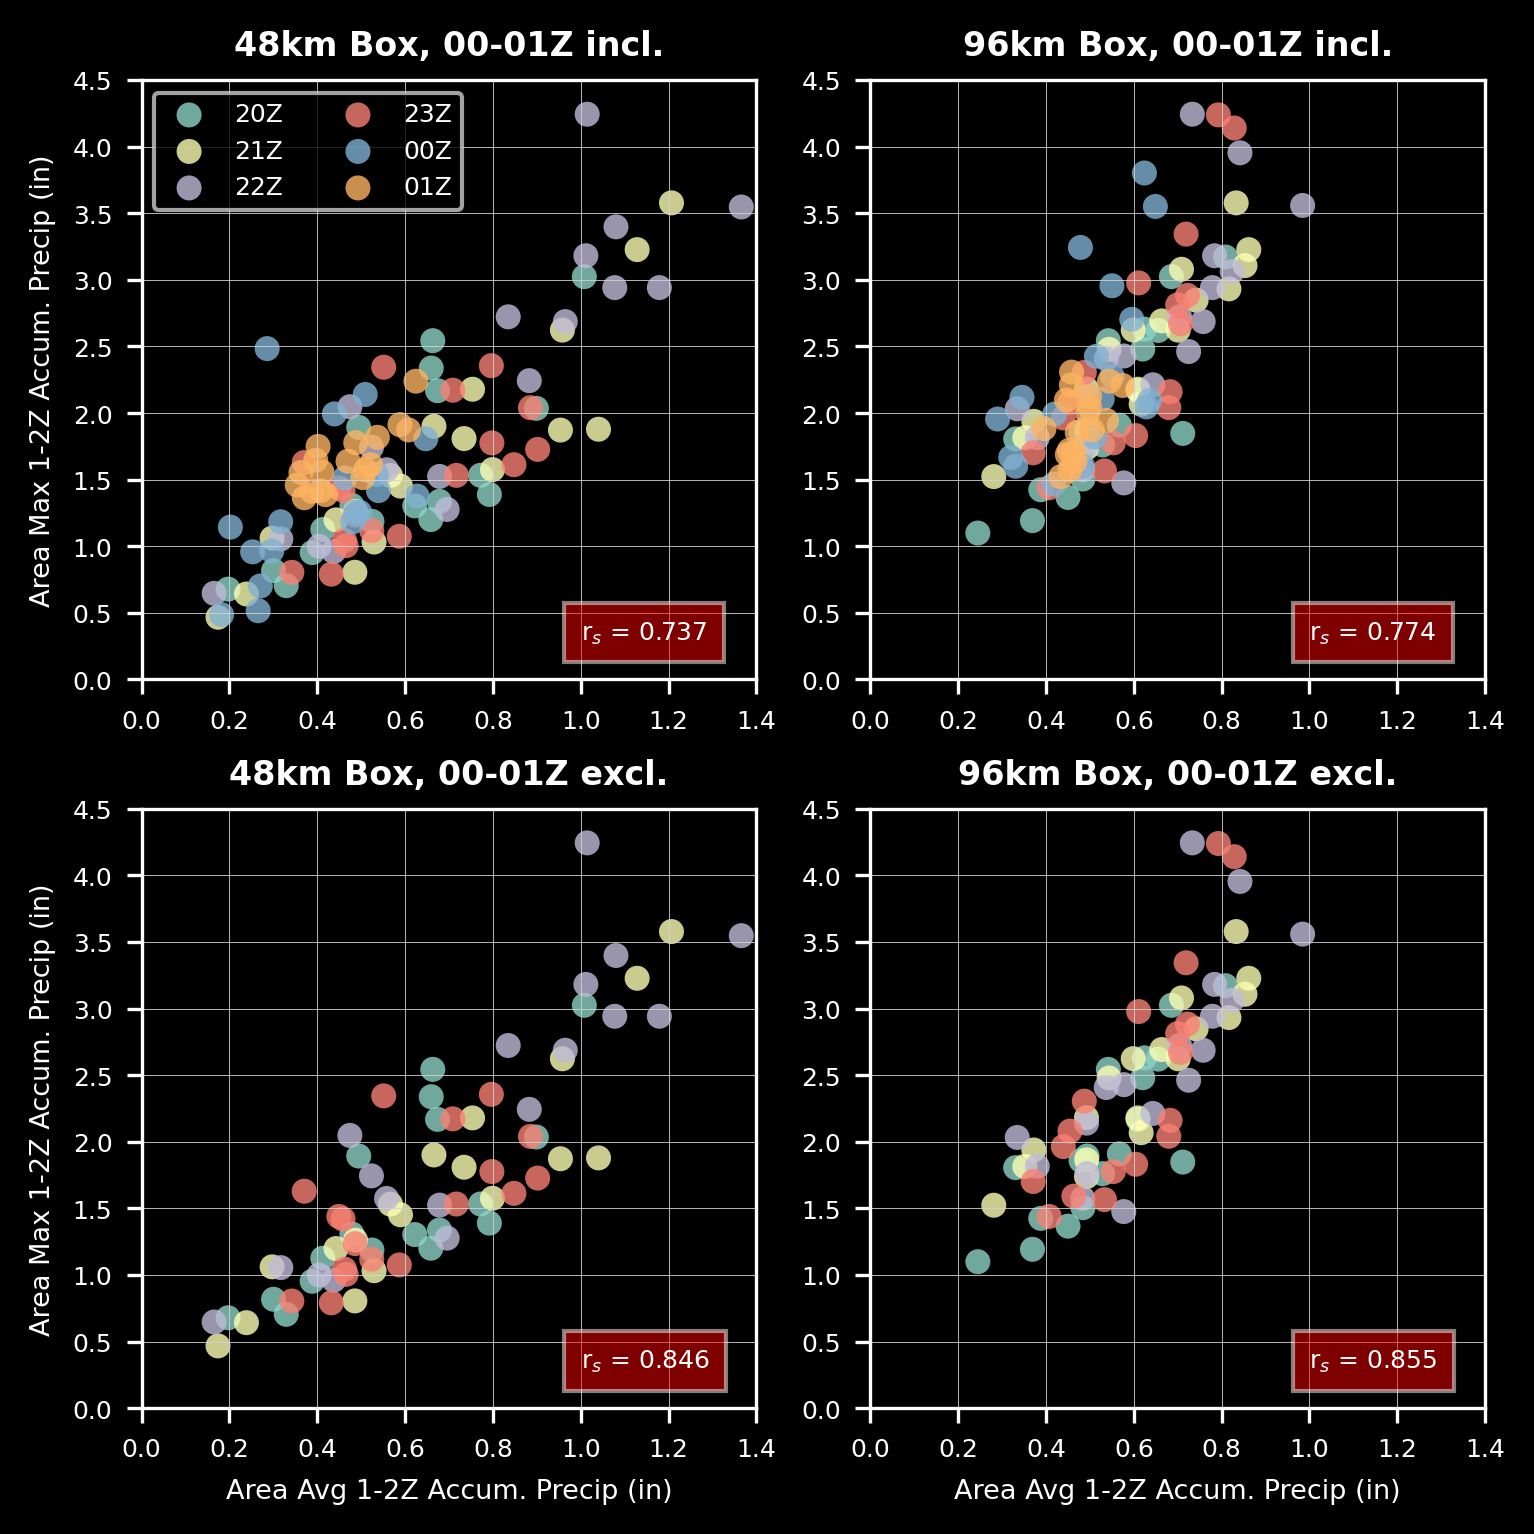

In [47]:
# Create 2x2 scatterplots

plt.style.use("dark_background")
x_top = [avg_48km,avg_96km]
y_top = [max_48km,max_96km]
x_bot = [avg_48km[:-2],avg_96km[:-2]]
y_bot = [max_48km[:-2],max_96km[:-2]]
titles = ["48km Box, 00-01Z incl.","96km Box, 00-01Z incl.",
          "48km Box, 00-01Z excl.","96km Box, 00-01Z excl."]
labels_top = ["20Z","21Z","22Z","23Z","00Z","01Z"]
labels_bot = ["20Z","21Z","22Z","23Z"]

fig,axes = plt.subplots(2,2,sharex=True,sharey=True,
                        dpi=300,layout="constrained",figsize=(5,5))

for i,ax in enumerate(axes.flatten()):
    if(i<2):
        for j in range(len(x_top[i])):
            ax.scatter(x_top[i][j],y_top[i][j],label=labels_top[j],
                    alpha=0.8,edgecolors="none")
    else:
        for j in range(len(x_bot[i-2])):
            ax.scatter(x_bot[i-2][j],y_bot[i-2][j],label=labels_bot[j],
                       alpha=0.8,edgecolors="none")
            
            ax.set_xlabel("Area Avg 1-2Z Accum. Precip (in)",fontsize=6.5)
    ax.tick_params(axis="x",which="both",labelsize=6,labelbottom=True)
    ax.tick_params(axis="y",which="both",labelsize=6,labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_xlim(0,1.4)
    ax.set_ylim(0,4.5)
    ax.set_title(titles[i],fontsize=8,fontweight="bold")
    ax.text(1,0.3,"r$_s$ = "+str(rs[i].round(3)),
            fontsize=6,bbox=dict(facecolor='red', alpha=0.5))

axes[0,0].legend(loc="best",fontsize=6,ncol=2)
axes[0,0].set_ylabel("Area Max 1-2Z Accum. Precip (in)",fontsize=6.5)
axes[1,0].set_ylabel("Area Max 1-2Z Accum. Precip (in)",fontsize=6.5)

plt.show()

## Density map of precip & UH

In [51]:
# Get the 5-minute precipitation and UH from 1-2Z
rain_1hr = [e.rain.sel(time=slice("2021-09-02 01:05:00",
                                   "2021-09-02 02:00:00")).sum(dim="time")
                                    for e in ens]
uh_1hr_15km = [e.uh_0to2_instant.sel(time=slice("2021-09-02 01:05:00",
                                   "2021-09-02 02:00:00")).rolling(
                                       lat=5,lon=5,min_periods=1,center=True
                                   ).max().max(dim="time") for e in ens]

In [52]:
# Concatenate our list of DataArrays
# Make a new DataArray
init = xr.DataArray(data=["20Z","21Z","22Z","23Z","00Z","01Z"],dims="init")
init = init.assign_coords({"init":init})

# Concat
rain_1hr = xr.concat(rain_1hr,dim=init)
uh_1hr_15km = xr.concat(uh_1hr_15km,dim=init)

# Make 2-dimensional histogram
h,xe,ye = np.histogram2d(rain_1hr.values.flatten(),uh_1hr_15km.values.flatten(),
                         bins=100)

In [53]:
# Prepare to plot

# Set cutoff for x-axis
cutoff = 1.0

# Create centered points
xc,yc = (xe[:-1] + xe[1:])/2,(ye[:-1] + ye[1:])/2

# Make 2D
X,Y = np.meshgrid(xc[xc>cutoff],yc)

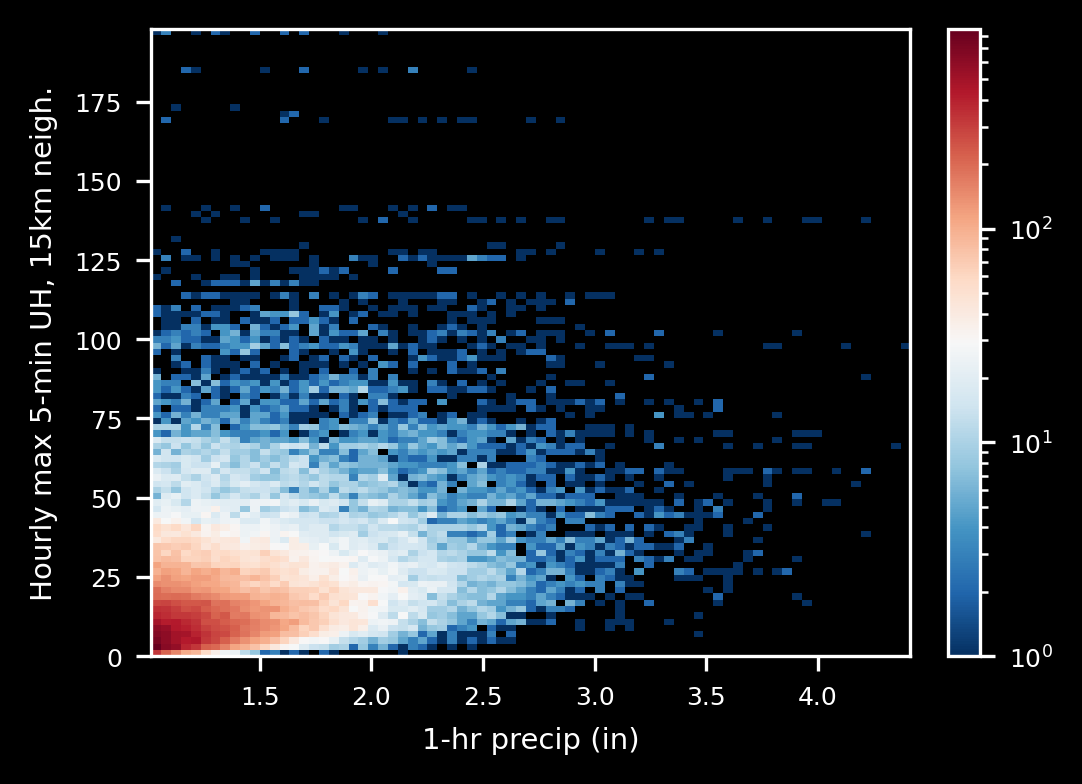

In [54]:
plt.style.use("dark_background")
fig,ax = plt.subplots(ncols=1,nrows=1,dpi=300,layout="constrained",figsize=(3.5,2.5))
plt.pcolormesh(X,Y,h[xc>cutoff].T,shading="nearest",norm=colors.LogNorm(),
               cmap="RdBu_r")
ax.set_xlabel("1-hr precip (in)",fontsize=7)
ax.set_ylabel("Hourly max 5-min UH, 15km neigh.",fontsize=7)
ax.tick_params(axis="both",which="both",labelsize=6)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=6)
plt.show()